In [1]:
from google.colab import drive
drive.mount('/content/drive')

#Import the libraries
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Fruits.zip', 'r') #Opens the zip file in read mode
zip_ref.extractall('/tmp') #Extracts the files into the /tmp folder
zip_ref.close()



import shutil # high level operations on files
# Mac create automatically the folder '_MACOSX'. Needed to be deleted.

directory_to_delete = '/tmp/__MACOSX'

# Check if the directory exists before attempting to remove it
if os.path.exists(directory_to_delete) and os.path.isdir(directory_to_delete):
    # Remove the directory and its contents
    shutil.rmtree(directory_to_delete)
    print(f"Directory '{directory_to_delete}' and its contents have been deleted.")
else:
    print(f"Directory '{directory_to_delete}' does not exist or is not a directory.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Directory '/tmp/__MACOSX' and its contents have been deleted.


In [2]:
directory_path = '/tmp/Fruits'
file_name_to_delete = '.DS_Store'
file_path = os.path.join(directory_path, file_name_to_delete)

if os.path.exists(file_path) and os.path.isfile(file_path):
    os.remove(file_path)
    print(f"The file '{file_name_to_delete}' in '{directory_path}' has been deleted.")
else:
    print(f"The file '{file_name_to_delete}' does not exist in '{directory_path}' or is not a file.")


The file '.DS_Store' in '/tmp/Fruits' has been deleted.


In [3]:
directory_path = '/tmp/Fruits'
file_name_to_check = '.DS_Store'
file_path = os.path.join(directory_path, file_name_to_check)

if os.path.exists(file_path) and os.path.isfile(file_path):
    print(f"The file '{file_name_to_check}' exists in '{directory_path}'.")
else:
    print(f"The file '{file_name_to_check}' does not exist in '{directory_path}'.")

The file '.DS_Store' does not exist in '/tmp/Fruits'.


In [4]:
%%capture
!pip install pytorch-fid
!pip install torchmetrics
!pip install torch-fidelity
!pip install torchinfo
!pip install matplotlib==3.5 #with newer versions of matplotlib this notebook might not run
%matplotlib inline
!pip install captum==0.5

In [5]:
# Import necessary libraries
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import random
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
from PIL import Image
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import cv2
import torchvision.transforms as T
import torchvision.transforms.functional as F
import time
from torch.utils.data import random_split
from collections import Counter
import datetime
from torchvision.utils import make_grid
import torch.optim as optim
from matplotlib import gridspec
from numpy import linspace, asarray
from numpy.random import randn
from torch.nn import functional as F
from tqdm import tqdm
import IPython.display
import torch.backends.cudnn as cudnn
import torchvision.utils as vutils
import PIL.Image
import io
from IPython.display import HTML
from pytorch_fid.fid_score import calculate_fid_given_paths
import uuid
from torchmetrics.image.inception import InceptionScore
from torchvision.utils import save_image
from torchinfo import summary

In [6]:
# Create a class for handling the Fruit dataset
class Fruits(Dataset):
    def __init__(self, image_dir, transforms=None):
        self.transforms = transforms
        self.files = []

        split = "train"
        self.image_dir = Path(image_dir) / split
        folders = sorted([folder for folder in os.listdir(self.image_dir) if os.path.isdir(self.image_dir / folder)])

        for folder in folders:
            class_idx = folders.index(folder)
            folder_dir = self.image_dir / folder
            files = os.listdir(folder_dir)

            for x in files:
                file_path = folder_dir / x

                # Check if the file is a valid image file
                if self.is_valid_image_file(file_path):
                    self.files.append({"file": file_path, "class": class_idx})

    def is_valid_image_file(self, file_path):
        try:
            img = Image.open(file_path)
            img.verify()
            return True
        except:
            return False

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        item = self.files[i]
        file = str(item['file'])
        class_idx = item['class']

        img = Image.open(file).convert("RGB")
        if self.transforms is not None:
            img = self.transforms(img)
            return img, class_idx, file
        img = transforms.ToTensor()(img)
        return img, class_idx, file


In [7]:
# Define some directories and file names to check and manipulate files
directory_to_delete = '/tmp/__MACOSX'
file_name_to_delete = '.DS_Store'
file_name_to_check = '.DS_Store'

# Define some parameters for the GAN
image_size = 64
n_classes = 5
embedding_dim = 100
z_dim = 100
outf = "output"

# Define transforms for image preprocessing
transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [8]:
# Initialize the dataset and dataloader
image_dir = "/tmp/Fruits"
dataset = Fruits(image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

In [9]:
# Create a Generator class
class Generator(nn.Module):
    # Constructor for the Generator class
    def __init__(self):
        super(Generator, self).__init__()

        self.label_conditioned_generator = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                                                         nn.Linear(embedding_dim, 16))

        self.latent = nn.Sequential(nn.Linear(z_dim, 4*4*512),
                                    nn.LeakyReLU(0.2, inplace=True))

        self.model = nn.Sequential(nn.ConvTranspose2d(513, 64*8, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*8, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*8, 64*4, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*4, 64*2, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.ReLU(True),
                                   nn.ConvTranspose2d(64*2, 3, 4, 2, 1, bias=False),
                                   nn.Tanh())

    # Forward method for the Generator
    def forward(self, inputs):
        noise_vector, label = inputs
        label_output = self.label_conditioned_generator(label)
        label_output = label_output.view(-1, 1, 4, 4)
        latent_output = self.latent(noise_vector)
        latent_output = latent_output.view(-1, 512, 4, 4)
        concat = torch.cat((latent_output, label_output), dim=1)
        image = self.model(concat)
        return image

In [10]:
# Create a Discriminator class
class Discriminator(nn.Module):
    # Constructor for the Discriminator class
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_condition_disc = nn.Sequential(nn.Embedding(n_classes, embedding_dim),
                                                  nn.Linear(embedding_dim, 3*64*64))

        self.model = nn.Sequential(nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64, 64*2, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*2, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Conv2d(64*2, 64*4, 4, 2, 1, bias=False),
                                   nn.BatchNorm2d(64*4, momentum=0.1,  eps=0.8),
                                   nn.LeakyReLU(0.2, inplace=True),
                                   nn.Flatten(),
                                   nn.Dropout(0.4),
                                   nn.Linear(64*8*8*4, 1),
                                   nn.Sigmoid())

    # Forward method for the Discriminator
    def forward(self, inputs):
        img, label = inputs
        label_output = self.label_condition_disc(label)
        label_output = label_output.view(-1, 3, 64, 64)
        concat = torch.cat((img, label_output), dim=1)
        output = self.model(concat)
        return output

In [11]:
# Custom weights initialization for both Generator and Discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') !=-1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [12]:
#We can use our GPU if it's available
print(torch.cuda.is_available())
dev = torch.device('cuda')
print(dev)

True
cuda


In [13]:
# Create instances of the Generator
generator = Generator().to(dev)
generator.apply(weights_init)


Generator(
  (label_conditioned_generator): Sequential(
    (0): Embedding(5, 100)
    (1): Linear(in_features=100, out_features=16, bias=True)
  )
  (latent): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model): Sequential(
    (0): ConvTranspose2d(513, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_siz

In [14]:
# Create instances of Discriminator
discriminator = Discriminator().to(dev)
discriminator.apply(weights_init)

Discriminator(
  (label_condition_disc): Sequential(
    (0): Embedding(5, 100)
    (1): Linear(in_features=100, out_features=12288, bias=True)
  )
  (model): Sequential(
    (0): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.4, inplace=False)
    (10): Linear(in_features=16384, out_features=1, bias=True)
    (11): Sigmoid()
  )
)

In [15]:
# Loss function
criterion = nn.BCELoss()

# Define the optimizers for the Generator and Discriminator
G_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Functions for calculating generator and discriminator losses
def generator_loss(label, fake_output):
    gen_loss = criterion(label, fake_output)
    return gen_loss

def discriminator_loss(label, output):
    disc_loss = criterion(label, output)
    return disc_loss



In [16]:

num_epochs = 1000
D_loss_plot, G_loss_plot, all_fid = [], [], []

if os.path.exists("Training_images"):
  shutil.rmtree('Training_images')

transform_fid = T.Compose([
    T.Resize((image_size,image_size))])

image_dir = "/tmp/Fruits"
training_fid = Fruits(image_dir, transforms=transform_fid)

os.makedirs('Training_images')
for idx in tqdm(range(len(training_fid))):
  img, label, _ = training_fid.__getitem__(idx)
  img.save(f"Training_images/{idx}.png")

100%|██████████| 2374/2374 [00:10<00:00, 229.62it/s]


In [17]:
if os.path.exists("image_created"):
  shutil.rmtree('image_created')

if os.path.exists(outf):
  shutil.rmtree(outf)

try:
    os.makedirs(outf)
except OSError:
  pass

def normalize_images_IS(images): #IS wants input between [0,1]
    # Normalize a batch of images to be between 0 and 1
    max_value = torch.max(images)
    min_value = torch.min(images)
    normalized_images = (images - min_value) / (max_value - min_value)
    return normalized_images

for epoch in range(1, num_epochs+1):

    D_loss_list, G_loss_list = [], []

    for index, (real_images, labels, _) in enumerate(dataloader):
        D_optimizer.zero_grad()
        # Real Data
        real_images = real_images.to(dev)
        # Real labels
        labels = labels.to(dev)
        labels = labels.unsqueeze(1).long()

        #Real and fake labels (real = 1, fake = 0)
        real_target = torch.ones(real_images.size(0), 1).to(dev)
        fake_target = torch.zeros(real_images.size(0), 1).to(dev)

        D_real_loss = discriminator_loss(discriminator((real_images, labels)), real_target)

        # Create the noise (starting of the fake images)
        noise_vector = torch.randn(real_images.size(0), z_dim, device=dev)
        noise_vector = noise_vector.to(dev)

        generated_image = generator((noise_vector, labels))
        output = discriminator((generated_image.detach(), labels))
        D_fake_loss = discriminator_loss(output,  fake_target)

        # train with fake
        D_total_loss = (D_real_loss + D_fake_loss) / 2
        D_loss_list.append(D_total_loss)

        D_total_loss.backward()
        D_optimizer.step()

        # Train generator with real labels
        G_optimizer.zero_grad()
        G_loss = generator_loss(discriminator((generated_image, labels)), real_target)
        G_loss_list.append(G_loss)

        G_loss.backward()
        G_optimizer.step()

    if epoch % 20 == 0 or epoch == 1:
      vutils.save_image(real_images[0], '%s/real_samples.png' % outf, normalize=True)
      #  fake = generator(noise_vector)
      vutils.save_image(generated_image.detach(), '%s/fake_samples_epoch_%03d.png' % (outf, epoch), normalize=True)

    D_loss_plot.append(torch.mean(torch.FloatTensor(D_loss_list)))
    G_loss_plot.append(torch.mean(torch.FloatTensor(G_loss_list)))

    #FID and IS calculated every 250 epochs
    if epoch % 250 == 0 or epoch == 1:
      try:
        os.makedirs("image_created")
      except OSError:
        pass
      for _ in tqdm(range(37)):  #like dataloader
        with torch.no_grad():
          noise_vector = torch.randn(64, z_dim, device=dev)   #64 is the batch, ma è come se fossero righe e z_dim le colonne. Aggiornando sempre il noise vector, facciamo si che per ogni batch il noise di partenza sa diverso  quindi gneera immagini diverse per ogni batch
          fake_imgs = generator((noise_vector, labels))
        for idx in range(fake_imgs.shape[0]):
          fake_img= fake_imgs[idx]
          vutils.save_image(fake_img,f"image_created/{str(uuid.uuid4())}.png",normalize=True)
      fid = calculate_fid_given_paths(['Training_images','image_created'],dims=2048, device = 'cuda',batch_size=64)
      fake_imgs = normalize_images_IS(fake_imgs.cpu())  #to be sure that values are normalized between [0,1]
      inception = InceptionScore(normalize = True)  #to make the inception score accept values between [0,1]
      inception.update(fake_imgs)
      all_fid.append(fid)
      print('Epoch: [%d/%d]: D_loss: %.3f | G_loss: %.3f | IS = mean:%.2f, std:%.2f | FID=%.2f' % (
           (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
           torch.mean(torch.FloatTensor(G_loss_list)), inception.compute()[0], inception.compute()[1], fid))
      # do checkpointing
      torch.save(generator.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
      torch.save(discriminator.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
      shutil.rmtree('image_created')
    else:
      print('Epoch: [%d/%d]: D_loss: %.3f | G_loss: %.3f' % (
           (epoch), num_epochs, torch.mean(torch.FloatTensor(D_loss_list)),\
           torch.mean(torch.FloatTensor(G_loss_list))))

100%|██████████| 37/37 [00:05<00:00,  6.96it/s]
Downloading: "https://github.com/mseitzer/pytorch-fid/releases/download/fid_weights/pt_inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/pt_inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 157MB/s]
100%|██████████| 37/37 [00:08<00:00,  4.35it/s]
/usr/local/lib/python3.10/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)  # noqa: B028
Downloading: "https://github.com/toshas/torch-fidelity/releases/download/v0.2.0/weights-inception-2015-12-05-6726825d.pth" to /root/.cache/torch/hub/checkpoints/weights-inception-2015-12-05-6726825d.pth
100%|██████████| 91.2M/91.2M [00:00<00:00, 131MB/s]


Epoch: [1/1000]: D_loss: 0.487 | G_loss: 1.026 | IS = mean:1.41, std:0.16 | FID=355.42
Epoch: [2/1000]: D_loss: 0.298 | G_loss: 2.750
Epoch: [3/1000]: D_loss: 0.203 | G_loss: 3.054
Epoch: [4/1000]: D_loss: 0.247 | G_loss: 3.348
Epoch: [5/1000]: D_loss: 0.334 | G_loss: 2.438
Epoch: [6/1000]: D_loss: 0.437 | G_loss: 1.800
Epoch: [7/1000]: D_loss: 0.464 | G_loss: 1.691
Epoch: [8/1000]: D_loss: 0.462 | G_loss: 1.654
Epoch: [9/1000]: D_loss: 0.473 | G_loss: 1.586
Epoch: [10/1000]: D_loss: 0.532 | G_loss: 1.473
Epoch: [11/1000]: D_loss: 0.522 | G_loss: 1.389
Epoch: [12/1000]: D_loss: 0.569 | G_loss: 1.341
Epoch: [13/1000]: D_loss: 0.556 | G_loss: 1.285
Epoch: [14/1000]: D_loss: 0.563 | G_loss: 1.215
Epoch: [15/1000]: D_loss: 0.550 | G_loss: 1.249
Epoch: [16/1000]: D_loss: 0.559 | G_loss: 1.206
Epoch: [17/1000]: D_loss: 0.572 | G_loss: 1.164
Epoch: [18/1000]: D_loss: 0.566 | G_loss: 1.075
Epoch: [19/1000]: D_loss: 0.584 | G_loss: 1.065
Epoch: [20/1000]: D_loss: 0.586 | G_loss: 1.024
Epoch: [2

100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch: [250/1000]: D_loss: 0.405 | G_loss: 2.077 | IS = mean:2.48, std:0.70 | FID=187.18
Epoch: [251/1000]: D_loss: 0.395 | G_loss: 2.097
Epoch: [252/1000]: D_loss: 0.367 | G_loss: 2.047
Epoch: [253/1000]: D_loss: 0.402 | G_loss: 2.069
Epoch: [254/1000]: D_loss: 0.392 | G_loss: 2.087
Epoch: [255/1000]: D_loss: 0.371 | G_loss: 2.106
Epoch: [256/1000]: D_loss: 0.398 | G_loss: 2.128
Epoch: [257/1000]: D_loss: 0.368 | G_loss: 2.132
Epoch: [258/1000]: D_loss: 0.372 | G_loss: 2.133
Epoch: [259/1000]: D_loss: 0.404 | G_loss: 2.181
Epoch: [260/1000]: D_loss: 0.411 | G_loss: 2.117
Epoch: [261/1000]: D_loss: 0.382 | G_loss: 2.109
Epoch: [262/1000]: D_loss: 0.388 | G_loss: 2.115
Epoch: [263/1000]: D_loss: 0.392 | G_loss: 2.146
Epoch: [264/1000]: D_loss: 0.376 | G_loss: 2.136
Epoch: [265/1000]: D_loss: 0.394 | G_loss: 2.096
Epoch: [266/1000]: D_loss: 0.383 | G_loss: 2.114
Epoch: [267/1000]: D_loss: 0.387 | G_loss: 2.096
Epoch: [268/1000]: D_loss: 0.373 | G_loss: 2.119
Epoch: [269/1000]: D_loss: 0.

100%|██████████| 37/37 [00:08<00:00,  4.16it/s]


Epoch: [500/1000]: D_loss: 0.355 | G_loss: 2.581 | IS = mean:2.45, std:0.79 | FID=189.10
Epoch: [501/1000]: D_loss: 0.342 | G_loss: 2.593
Epoch: [502/1000]: D_loss: 0.389 | G_loss: 2.515
Epoch: [503/1000]: D_loss: 0.351 | G_loss: 2.543
Epoch: [504/1000]: D_loss: 0.355 | G_loss: 2.556
Epoch: [505/1000]: D_loss: 0.333 | G_loss: 2.570
Epoch: [506/1000]: D_loss: 0.361 | G_loss: 2.568
Epoch: [507/1000]: D_loss: 0.421 | G_loss: 2.580
Epoch: [508/1000]: D_loss: 0.356 | G_loss: 2.539
Epoch: [509/1000]: D_loss: 0.342 | G_loss: 2.538
Epoch: [510/1000]: D_loss: 0.383 | G_loss: 2.578
Epoch: [511/1000]: D_loss: 0.363 | G_loss: 2.531
Epoch: [512/1000]: D_loss: 0.337 | G_loss: 2.483
Epoch: [513/1000]: D_loss: 0.352 | G_loss: 2.520
Epoch: [514/1000]: D_loss: 0.353 | G_loss: 2.557
Epoch: [515/1000]: D_loss: 0.346 | G_loss: 2.576
Epoch: [516/1000]: D_loss: 0.356 | G_loss: 2.693
Epoch: [517/1000]: D_loss: 0.346 | G_loss: 2.569
Epoch: [518/1000]: D_loss: 0.353 | G_loss: 2.515
Epoch: [519/1000]: D_loss: 0.

100%|██████████| 37/37 [00:08<00:00,  4.14it/s]


Epoch: [750/1000]: D_loss: 0.363 | G_loss: 2.678 | IS = mean:2.50, std:0.57 | FID=186.01
Epoch: [751/1000]: D_loss: 0.359 | G_loss: 2.604
Epoch: [752/1000]: D_loss: 0.360 | G_loss: 2.672
Epoch: [753/1000]: D_loss: 0.384 | G_loss: 2.598
Epoch: [754/1000]: D_loss: 0.359 | G_loss: 2.707
Epoch: [755/1000]: D_loss: 0.358 | G_loss: 2.691
Epoch: [756/1000]: D_loss: 0.350 | G_loss: 2.669
Epoch: [757/1000]: D_loss: 0.334 | G_loss: 2.671
Epoch: [758/1000]: D_loss: 0.358 | G_loss: 2.708
Epoch: [759/1000]: D_loss: 0.354 | G_loss: 2.750
Epoch: [760/1000]: D_loss: 0.364 | G_loss: 2.588
Epoch: [761/1000]: D_loss: 0.409 | G_loss: 2.710
Epoch: [762/1000]: D_loss: 0.384 | G_loss: 2.676
Epoch: [763/1000]: D_loss: 0.353 | G_loss: 2.597
Epoch: [764/1000]: D_loss: 0.365 | G_loss: 2.677
Epoch: [765/1000]: D_loss: 0.372 | G_loss: 2.637
Epoch: [766/1000]: D_loss: 0.336 | G_loss: 2.598
Epoch: [767/1000]: D_loss: 0.386 | G_loss: 2.610
Epoch: [768/1000]: D_loss: 0.355 | G_loss: 2.627
Epoch: [769/1000]: D_loss: 0.

100%|██████████| 37/37 [00:08<00:00,  4.12it/s]


Epoch: [1000/1000]: D_loss: 0.356 | G_loss: 2.756 | IS = mean:2.46, std:0.68 | FID=188.43


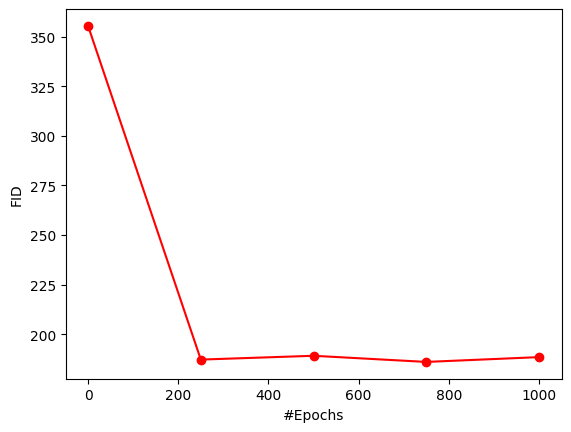

In [18]:
# FID

x = [i * 250 for i in range(0,len(all_fid))]
plt.ylabel("FID")
plt.xlabel("#Epochs")
plt.plot(x,all_fid, 'o-r') # plot x and y using blue circle markers
plt.show()

In [19]:
def showarray(a, b = None, fmt='png', title1 = None, title2 = None):
    a = (a - a.min())
    a = a /a.max()
    a = np.uint8(a*255)

    fa = io.BytesIO()
    PIL.Image.fromarray(a).save(fa, fmt)
    if(b!=None):
      b = (b - b.min())
      b = b / b.max()
      b = np.uint8(b * 255)
      fb = io.BytesIO()
      PIL.Image.fromarray(b).save(fb, fmt)
      fig, ax = plt.subplots(1, 2, figsize=(15, 15))
      ax[0].set_xticks([]); ax[0].set_yticks([])
      ax[1].set_xticks([]); ax[1].set_yticks([])
      ax[0].imshow(a)
      ax[0].title.set_text(title1)
      ax[1].imshow(b)
      ax[1].title.set_text(title2)
      plt.show()
    else:
      fig, ax = plt.subplots(figsize=(4, 4))
      ax.set_xticks([]); ax.set_yticks([])
      ax.imshow(a)
      ax.title.set_text(title1)
      plt.show()

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─Embedding: 2-1                    500
│    └─Linear: 2-2                       1,616
├─Sequential: 1-2                        --
│    └─Linear: 2-3                       827,392
│    └─LeakyReLU: 2-4                    --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-5              4,202,496
│    └─BatchNorm2d: 2-6                  1,024
│    └─ReLU: 2-7                         --
│    └─ConvTranspose2d: 2-8              2,097,152
│    └─BatchNorm2d: 2-9                  512
│    └─ReLU: 2-10                        --
│    └─ConvTranspose2d: 2-11             524,288
│    └─BatchNorm2d: 2-12                 256
│    └─ReLU: 2-13                        --
│    └─ConvTranspose2d: 2-14             6,144
│    └─Tanh: 2-15                        --
Total params: 7,661,380
Trainable params: 7,661,380
Non-trainable params: 0
Lay

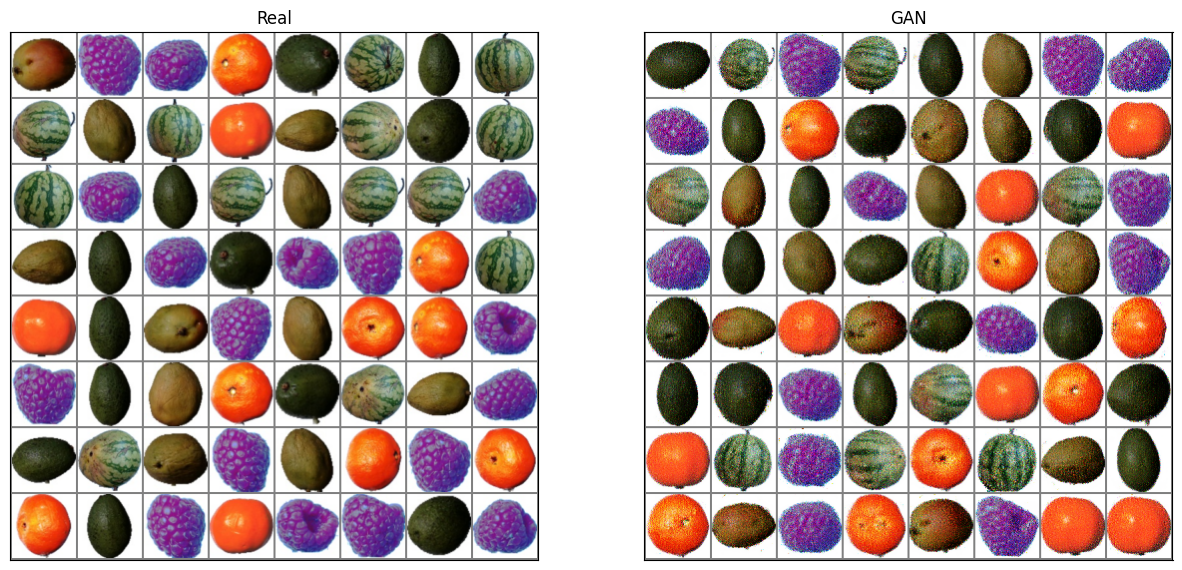

In [20]:
# Save the trained generator and discriminator models
torch.save(generator, 'generatorENTIRE.pth')
torch.save(discriminator, 'discriminatorENTIRE.pth')

# Load the trained models
generator = torch.load('generatorENTIRE.pth')
discriminator = torch.load('discriminatorENTIRE.pth')
generator.eval()
print(summary(generator))
print(summary(discriminator))

# Create grid images for real and generated samples
grid_img_real = vutils.make_grid(next(iter(dataloader))[0], nrow=8)
grid_img_GAN = vutils.make_grid(generated_image.cpu().detach(), nrow=8)
showarray(grid_img_real.permute(1, 2, 0), grid_img_GAN.permute(1, 2, 0), title1="Real", title2="GAN")

## Classification original dataset

In [21]:

# Specify your image directory, image size, and transformations
image_dir = "/tmp/Fruits"
image_size = 64
transform = T.Compose([
    T.Resize((image_size, image_size)),
    T.RandomHorizontalFlip(0.5),
    T.RandomVerticalFlip(0.5),
    T.ToTensor(),
    T.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [22]:
# Create a dataset and dataloader for your original dataset
dataset = Fruits(image_dir, transforms=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True, num_workers=2)

# Split your dataset into train, validation, and test sets
train_size = int(len(dataset) * 0.70)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - (train_size + val_size)
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

# Print the sizes of your sets
print(f'Training set size: {train_size}\nValidation set size: {val_size}\nTest set size: {test_size}')


Training set size: 1661
Validation set size: 356
Test set size: 357


In [23]:
# Create dataloaders for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False, drop_last=False, num_workers=2)
test_loader = DataLoader(test_set, batch_size=8, shuffle=False, drop_last=False, num_workers=2)

In [24]:
# Define a Sequential CNN model
class SeqCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        return x


In [25]:
# Create an instance of the SeqCNN model
seq_net = SeqCNN()
img_x, _, _ = train_set[0]
img_x = img_x.unsqueeze(dim=0)
output = seq_net(img_x)
print(output.shape)
out_features = output.size(1) * output.size(2) * output.size(3)
print(out_features)

torch.Size([1, 3, 24, 24])
1728


In [26]:

# Define a CNN model
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=3, out_channels=3, kernel_size=9, padding=0, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(out_features, 10),
            nn.ReLU(),
            nn.Linear(10, 5)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = x.view(x.size(0), -1)
        output = self.fc_layers(x)
        return output

In [27]:
# Create an instance of the CNN model
model = CNN()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a loss function
criterion = nn.CrossEntropyLoss()

In [28]:
# Function to train the model
def train(net, loaders, optimizer, criterion, epochs=5, dev=torch.device('cpu')):
    start_time = time.time() #(for showing time)
    try:
        net = net.to(dev)
    #    print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []} #, "test": []
        history_accuracy = {"train": [], "val": [], "test": []}  #, "test": []
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            sum_accuracy = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            # Process each split
            for split in ["train", "val", "test"]:  #, "test"
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels, _) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            # Update history
            for split in ["train", "val", "test"]:   #, "test"
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrACC={epoch_accuracy['train']:.4f},",
                  f"TrLoss={epoch_loss['train']:.4f} ||",
                  f"ValACC={epoch_accuracy['val']:.4f},",
                  f"ValLoss={epoch_loss['val']:.4f} ||",
                  f"TestACC={epoch_accuracy['test']:.4f},",
                  f"TestLoss={epoch_loss['test']:.4f} ||",
                  f"Overall time:{str(datetime.timedelta(seconds=int(time.time()- start_time)))}")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": train_loader,  #train_data_loader.
           "val": val_loader,   #test_data_loader
           "test": test_loader}

Epoch 1: TrACC=0.6630, TrLoss=0.8896 || ValACC=0.8639, ValLoss=0.2539 || TestACC=0.8722, TestLoss=0.3024 || Overall time:0:00:03
Epoch 2: TrACC=0.9221, TrLoss=0.2369 || ValACC=0.8861, ValLoss=0.2744 || TestACC=0.8494, TestLoss=0.3417 || Overall time:0:00:07
Epoch 3: TrACC=0.9710, TrLoss=0.0866 || ValACC=0.9889, ValLoss=0.0387 || TestACC=0.9778, TestLoss=0.0618 || Overall time:0:00:12
Epoch 4: TrACC=0.9921, TrLoss=0.0360 || ValACC=0.9917, ValLoss=0.0216 || TestACC=0.9806, TestLoss=0.0535 || Overall time:0:00:16
Epoch 5: TrACC=0.9879, TrLoss=0.0522 || ValACC=0.9972, ValLoss=0.0148 || TestACC=0.9972, TestLoss=0.0163 || Overall time:0:00:19


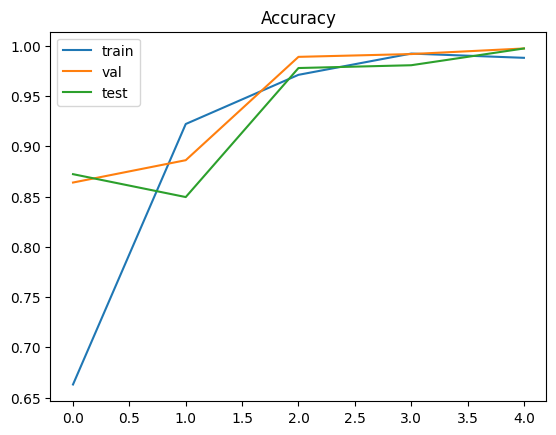

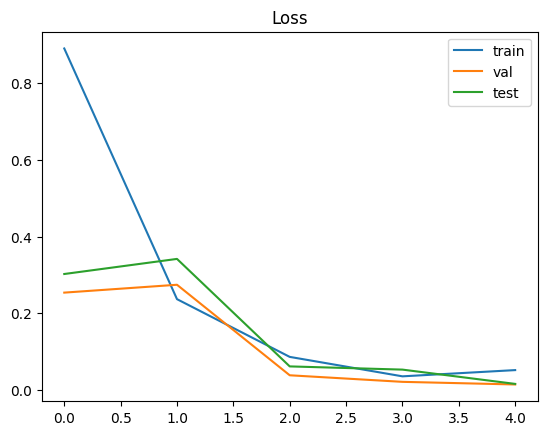

In [29]:
# Train the model

train(model, loaders, optimizer, criterion, epochs=5, dev=dev)


In [30]:
# Save the trained model
torch.save(model, 'model.pth')

In [31]:
# Generate fake images for classification using GAN

if os.path.exists("Fake_images_for_classification"):
  shutil.rmtree('Fake_images_for_classification')

os.makedirs('Fake_images_for_classification/train/avocado')
os.makedirs('Fake_images_for_classification/train/clementine')
os.makedirs('Fake_images_for_classification/train/papaya')
os.makedirs('Fake_images_for_classification/train/raspberry')
os.makedirs('Fake_images_for_classification/train/watermelon')



label0 = torch.tensor([0]).to(dev)
label0 = label0.unsqueeze(1).long()
label1 = torch.tensor([1]).to(dev)
label1 = label1.unsqueeze(1).long()
label2 = torch.tensor([2]).to(dev)
label2 = label2.unsqueeze(1).long()
label3 = torch.tensor([3]).to(dev)
label3 = label3.unsqueeze(1).long()
label4 = torch.tensor([4]).to(dev)
label4 = label4.unsqueeze(1).long()

generator.eval()

label_list = [label0, label1, label2, label3, label4]
class_list = ['avocado', 'clementine', 'papaya', 'raspberry', 'watermelon']

for class_idx, class_label in enumerate(class_list):
    for i in range(100):
        noise_vector = torch.randn(1, z_dim, device=dev)
        generated_single_image = generator((noise_vector, label_list[class_idx]))
        save_image(generated_single_image.data[0].detach(), f"Fake_images_for_classification/train/{class_label}/{class_label}_{i}.png", nrow=5, normalize=True)


In [32]:
# Define new dataset (original + fake)
image_dir = "Fake_images_for_classification"
dataset_GAN = Fruits(image_dir, transforms=transform)
concat_training_set = ConcatDataset([train_set, dataset_GAN])
print(f'Training set (of original training images + gan images): {len(concat_training_set)}')
concat_dataloader = DataLoader(concat_training_set, batch_size=64, shuffle=True, drop_last = True, num_workers = 2)


Training set (of original training images + gan images): 2161


In [33]:
# Create an instance of the CNN model
model = CNN()

# Define an optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a loss function
criterion = nn.CrossEntropyLoss()

In [34]:
# Define train function
def train(net, loaders, optimizer, criterion, epochs=10, dev=torch.device('cpu')):
    start_time = time.time() #(for showing time)
    try:
        net = net.to(dev)
    #    print(net)
        # Initialize history
        history_loss = {"train": [], "val": [], "test": []} #, "test": []
        history_accuracy = {"train": [], "val": [], "test": []}  #, "test": []
        # Process each epoch
        for epoch in range(epochs):
            # Initialize epoch variables
            sum_loss = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            sum_accuracy = {"train": 0, "val": 0,"test": 0}  #,"test": 0
            # Process each split
            for split in ["train", "val", "test"]:  #, "test"
                if split == "train":
                  net.train()
                else:
                  net.eval()
                # Process each batch
                for (input, labels, _) in loaders[split]:
                    # Move to CUDA
                    input = input.to(dev)
                    labels = labels.to(dev)
                    # Reset gradients
                    optimizer.zero_grad()
                    # Compute output
                    outputs = net(input)
                    loss = criterion(outputs, labels)
                    # Update loss
                    sum_loss[split] += loss.item()
                    # Check parameter update
                    if split == "train":
                        # Compute gradients
                        loss.backward()
                        # Optimize
                        optimizer.step()
                    # Compute accuracy
                    preds = torch.argmax(outputs, 1)
                    batch_accuracy = (preds == labels).sum().item()/input.size(0)
                    # Update accuracy
                    sum_accuracy[split] += batch_accuracy
            # Compute epoch loss/accuracy
            epoch_loss = {split: sum_loss[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            epoch_accuracy = {split: sum_accuracy[split]/len(loaders[split]) for split in ["train", "val", "test"]}  #, "test"
            # Update history
            for split in ["train", "val", "test"]:   #, "test"
                history_loss[split].append(epoch_loss[split])
                history_accuracy[split].append(epoch_accuracy[split])
            # Print info
            print(f"Epoch {epoch+1}:",
                  f"TrACC={epoch_accuracy['train']:.4f},",
                  f"TrLoss={epoch_loss['train']:.4f} ||",
                  f"ValACC={epoch_accuracy['val']:.4f},",
                  f"ValLoss={epoch_loss['val']:.4f} ||",
                  f"TestACC={epoch_accuracy['test']:.4f},",
                  f"TestLoss={epoch_loss['test']:.4f} ||",
                  f"Overall time:{str(datetime.timedelta(seconds=int(time.time()- start_time)))}")
    except KeyboardInterrupt:
        print("Interrupted")
    finally:
        # Plot accuracy
        plt.title("Accuracy")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_accuracy[split], label=split)
        plt.legend()
        plt.show()
        # Plot loss
        plt.title("Loss")
        for split in ["train", "val", "test"]:  #, "test"
            plt.plot(history_loss[split], label=split)
        plt.legend()
        plt.show()

# Define dictionary of loaders
loaders = {"train": concat_dataloader, #concat_dataloader,
           "val": val_loader,   #val_loader_GAN
           "test": test_loader}  #test_loader_GAN

Epoch 1: TrACC=0.5166, TrLoss=1.0202 || ValACC=0.7000, ValLoss=0.5204 || TestACC=0.6311, TestLoss=0.6126 || Overall time:0:00:03
Epoch 2: TrACC=0.8229, TrLoss=0.3667 || ValACC=0.9972, ValLoss=0.1427 || TestACC=1.0000, TestLoss=0.1550 || Overall time:0:00:08
Epoch 3: TrACC=0.9991, TrLoss=0.0735 || ValACC=1.0000, ValLoss=0.0177 || TestACC=1.0000, TestLoss=0.0182 || Overall time:0:00:11
Epoch 4: TrACC=0.9995, TrLoss=0.0148 || ValACC=1.0000, ValLoss=0.0071 || TestACC=1.0000, TestLoss=0.0069 || Overall time:0:00:14
Epoch 5: TrACC=0.9995, TrLoss=0.0072 || ValACC=1.0000, ValLoss=0.0038 || TestACC=1.0000, TestLoss=0.0039 || Overall time:0:00:18


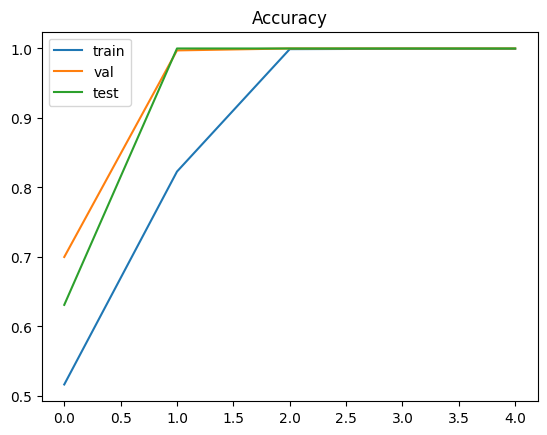

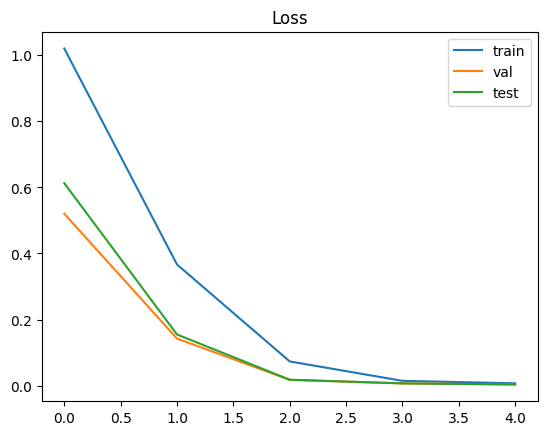

In [35]:
# Training
train(model, loaders, optimizer, criterion, epochs=5, dev=dev)

In [36]:
# Save the model
torch.save(model, 'model.pth')
